# Prophet Prediction

In [1]:
# Libraries
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns



Drug Classes:
- ANTIDIABETICS
- PAIN
- IMMUNOLOGY
- MENTAL HEALTH
- ADHD
- OTHER CNS
- OSTEOPOROSIS
- ERECTILE DYSFUNCTION
- ONCOLOGICS
- ANTICOAGULANTS
- VIRAL HEPATITIS
- IMMUNOSUPPRESSANTS
- HIV ANTIVIRALS
- ANTIBACTERIALS
- LIPID REGULATORS
- ANTIVIRALS, HERPES
- NERVOUS SYSTEM DISORDERS
- ANTI-OBESITY PREPS, EXCL. DIETETICS
- COUGH COLD, INCL FLU ANTIVIRALS
- VACCINES (PURE, COMB, OTHER)
- ANTIHYPERTENSIVES, PLAIN & COMBO
- ANTI-PARASITICS, ANTIMALARIALS, INSECTICIDES
- DERMATOLOGICS
- BPH (BENIGN PROSTATIC HYPERTROPHY)
- CANCER DETOX AG, ANTI-NAUSEANTS
- RESPIRATORY AGENTS
- SPEC IMMUNOGLOBULINS & ANTITOXIC SERA
- MIOTICS+ANTIGLAUCOMA PREPS
- SYST ANTIFUNGALS
- DIAGNOSTIC EQUIP & ACCESSORIES & ALLERGEN TESTS
- THROMBOPOIETIN AGONISTS
- ANTI-ULCERANTS
- SEX HORMONES (ANDROGENS, OESTROGENS, PROGESTOGENS,
- ANTITUBERCULARS
- OTHER CARDIOVASCULARS
- CORTICOSTEROIDS, PLAIN & COMBO
- HORMONAL CONTRACEPTION, SYSTEMIC&TOPICAL
- GENITO-URINARY ANTIBACTERIALS & ANTISEPTICS & ANTI
- URINARY INCONTINENCE
- HYPOTHALAMIC HORMONES
- GI PRODUCTS
- BLOOD COAGULATION
- OPHTHALMOLOGY, GENERAL
- ANTIGOUT PREPS
- HEMATOPOIETIC GROWTH FACTORS
- NASAL PREPS, TOPICAL
- ANTI-INFLAMMATORY AND DIGESTIVE ENZYMES AND MODULA
- ALLERGY, SYSTEMIC & NASAL
- ALL OTHER THERAPEUTICS
- J07D6 TUBERCULOSIS VACCINES
- EAR TREATMENTS&EYE-EAR COMBOS
- ERYTHROPOIETINS
- MULTIPLE SCLEROSIS
- THYROID ANTI-THYROID AND IODINE PREPS
- OTHER HORMONES
- ANTI-ALZHEIMERS
- BISPHOSPHONATES TUMOR-RELATED & BONY METASTASES
- OCULAR ANTINEOVASCULARISATION
- INTERFERONS, EXCL MS MARKET
- HOSPITAL SOLUTIONS
- ALL OTHER UROLOGICAL
- IMAGING
- OTHER ALIMENTARY TRACT AND METABOLISM PRODUCTS
- ANTI-ANAEMICS, IRON AND ALL COMBINATIONS
- ALL OTHER RESPIRATORY
- POLYVAL IMMUNOGLOBLULINS IV&IM
- GROWTH HORMONES
- LABOUR INDUCERS
- VITAMINS & MINERALS
- OTHER WOMEN'S HEALTH
- OTHER HAEMATOLOGICALS
- A05A1 CHOLERETICS+CHOLEKINETIC
- DIETETICS
- RESP ANTIVIRALS EX FLU
- A.C.T.H.

In [2]:
selected_class = 'VACCINES (PURE, COMB, OTHER)'

In [3]:
# Loading dataset
dataframe = pd.read_csv('../Processed_Data/drugs_pct_changes_monthly.csv')

# Only NDCs that have full period
last_period = dataframe[(dataframe.Year == 2020) & (dataframe.Month == 7)].NDC.unique()
first_period = dataframe[(dataframe.Year == 2014) & (dataframe.Month == 8)].NDC.unique()
dataframe.Date = pd.to_datetime(dataframe.Date, format='%Y_%m')
selected_NDC = list(set(last_period).intersection(first_period)) 
# dataframe = dataframe[dataframe.NDC.isin(selected_NDC)]

# Fill in the pct change NA by 0 (first values)
dataframe.Pct_change = dataframe.Pct_change.fillna(0)

# Fill in the Previous_TRx NA by latest value (first values)
dataframe.Previous_TRx = dataframe.Previous_TRx.fillna(method='ffill')

# Dropping before 2015 because 2014 is not good
dataframe = dataframe[dataframe.Date >= pd.to_datetime('2015-01-01')]

dataframe.head()


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed
3,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015-01-01,2015,1,21,22.0,21.0,244.16,0.00000,0
4,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015-02-01,2015,2,15,21.0,36.0,244.16,0.00000,0
5,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015-03-01,2015,3,33,15.0,69.0,244.16,0.00000,0
6,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015-04-01,2015,4,47,33.0,116.0,244.16,0.00000,0
7,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015-05-01,2015,5,36,47.0,152.0,265.90,0.08904,1


In [4]:
# Getting rid of NDC that do not have LOE date
# dataframe = dataframe[dataframe['Estimated LOE Date'] != 'Unspecified']

# Getting rid of NDC that are too close to their LOE date
# dataframe['Estimated LOE Date'] = pd.to_datetime(dataframe['Estimated LOE Date'], format='%b-%y')
# dataframe = dataframe[dataframe['Estimated LOE Date'] >= pd.to_datetime('2020-07-01')]

In [5]:
# Filtering for a single class
data_class = dataframe[dataframe['Major Class'] == selected_class].copy()
print('Size: ', len(data_class))
data_class.head()


Size:  7913


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed
11109,5010001,Wyeth Pharmaceuticals Inc a subsidiary of Pfi...,TRUMENBA 11/2014 PFZ,11/1/2014 0:00,Unspecified,"VACCINES (PURE, COMB, OTHER)",ACUTE,INJECTABLES,1,0.5,2018-04-01,2018,4,4,1489.0,4.0,267.242,0.0,0
11110,5010001,Wyeth Pharmaceuticals Inc a subsidiary of Pfi...,TRUMENBA 11/2014 PFZ,11/1/2014 0:00,Unspecified,"VACCINES (PURE, COMB, OTHER)",ACUTE,INJECTABLES,1,0.5,2018-05-01,2018,5,2,4.0,6.0,267.242,0.0,0
11111,5010001,Wyeth Pharmaceuticals Inc a subsidiary of Pfi...,TRUMENBA 11/2014 PFZ,11/1/2014 0:00,Unspecified,"VACCINES (PURE, COMB, OTHER)",ACUTE,INJECTABLES,1,0.5,2018-06-01,2018,6,10,2.0,16.0,267.242,0.0,0
11112,5010001,Wyeth Pharmaceuticals Inc a subsidiary of Pfi...,TRUMENBA 11/2014 PFZ,11/1/2014 0:00,Unspecified,"VACCINES (PURE, COMB, OTHER)",ACUTE,INJECTABLES,1,0.5,2018-07-01,2018,7,24,10.0,40.0,267.242,0.0,0
11113,5010001,Wyeth Pharmaceuticals Inc a subsidiary of Pfi...,TRUMENBA 11/2014 PFZ,11/1/2014 0:00,Unspecified,"VACCINES (PURE, COMB, OTHER)",ACUTE,INJECTABLES,1,0.5,2018-08-01,2018,8,13,24.0,53.0,267.242,0.0,0


In [6]:
# Helper function to compute the weighted WAC 
def weigthed_average(data, quantity, weights):
    try:
        return (data[quantity] * data[weights]).sum() / data[weights].sum()
    except ZeroDivisionError:
        return data[quantity]


# Creating a sales column
data_class['Sales'] = data_class['WAC'] * data_class['TRx']
df = data_class.groupby('Date').apply(weigthed_average, 'WAC', 'Sales').to_frame(name = 'Sales weighted WAC')
df.reset_index(inplace=True)
df.head()

,Date,Sales weighted WAC
0,2015-01-01,211.714182
1,2015-02-01,217.472635
2,2015-03-01,230.672189
3,2015-04-01,231.106403
4,2015-05-01,227.767896


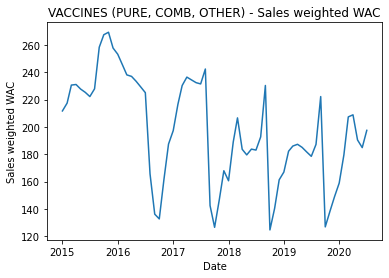

In [7]:
sns.lineplot(x=df.Date, y=df['Sales weighted WAC'])
plt.title(f'{selected_class} - Sales weighted WAC')
plt.show()

Total number of drugs in this class:  239


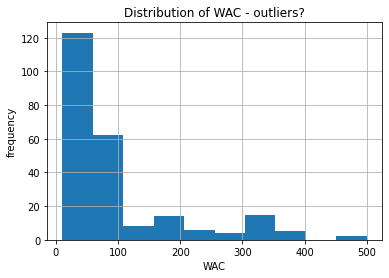

In [8]:
print('Total number of drugs in this class: ', data_class.NDC.nunique())

data_class.groupby('NDC').WAC.mean().hist()
plt.title('Distribution of WAC - outliers?')
plt.xlabel('WAC')
plt.ylabel('frequency')
plt.show()

# Prophet Model

In [9]:
def prophet_model(data, test_date=None, prediction_period=365, changepoint_prior_scale=.05):

    # Initiating test variable
    test_set = None

    # Reformating dataset for prophet
    df_prophet = data[['Date', 'Sales weighted WAC']].copy()
    df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Sales weighted WAC': 'y'})

    # Creating Prophet model
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)

    # Fitting model to training data excluding test dates
    if test_date is not None:
        model.fit(df_prophet[df_prophet.ds < pd.to_datetime(test_date)])
    else:
        model.fit(df_prophet)

    # Building predictions for train and test dates
    future = model.make_future_dataframe(periods=prediction_period, freq='MS')
    forecast = model.predict(future)

    # Ordering columns
    forecast = forecast[['ds', 'yhat'] + [c for c in forecast if c not in ['ds', 'yhat']]]

    # Creating test period dataset only
    if test_date is not None:
        forecast_test = model.predict(df_prophet)
        forecast_test['y'] = data['Sales weighted WAC'].values
        test_set = forecast_test[forecast_test.ds >= pd.to_datetime(test_date)][['ds', 'y', 'yhat']].copy()
        
    # Return model (for plotting), full forecast, and test period dataset
    return model, forecast, test_set

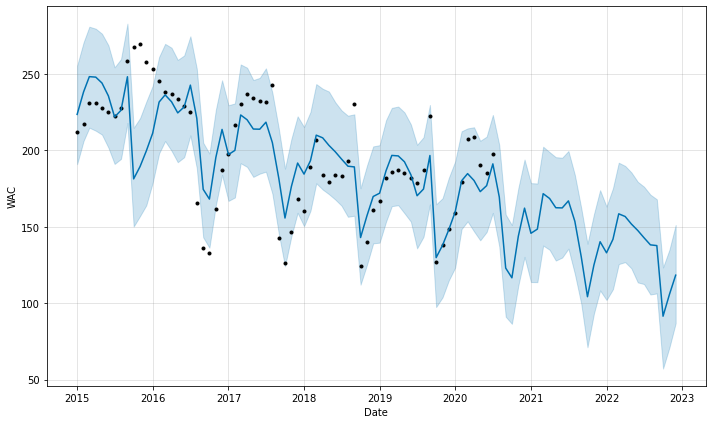

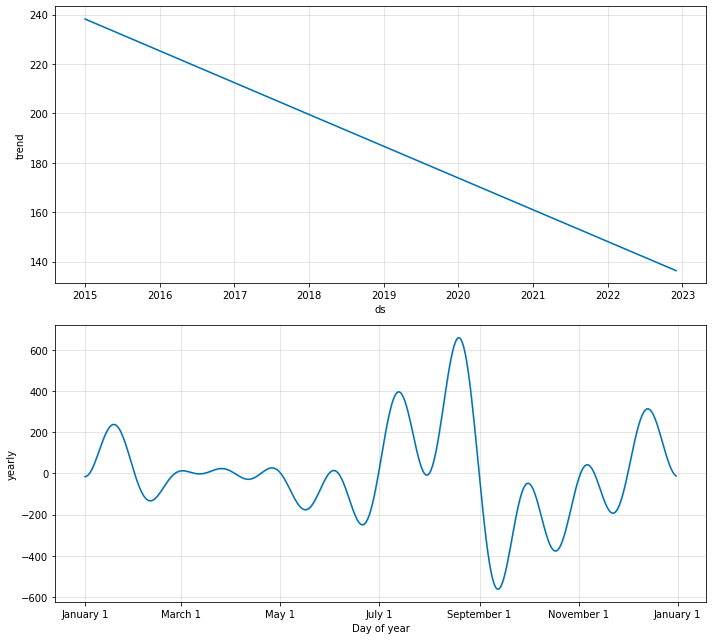

In [10]:
model, forecast, test_set = prophet_model(data=df, test_date=None, prediction_period=29, changepoint_prior_scale=.05)

# plotting results
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax);
if test_set is not None:
    sns.scatterplot(x= test_set.ds, y=test_set.y, color='orange', label='test')
    plt.legend()
    print('MAE on test period: ', mean_absolute_error(test_set.y, test_set.yhat))

plt.xlabel('Date')
plt.ylabel('WAC')
plt.show()


# plotting components
model.plot_components(forecast, figsize=(10, 9))
plt.show()


In [11]:
forecast = forecast.rename(columns={'ds': 'date'})
forecast.to_csv(f'Results/Method 2/{selected_class}.csv', index=False)